## Overview
The following is a notebook showcasing encoding the weights of neural networks within specific sets of numbers like the Fibonacci Numbers using a SNETwistEncoder and then benchmarking performance on classification and NLP tasks. 
## The Big idea
Use the inherint properties of numbers Fibonacci -> golden ratio to be able to have the model understand a pre-defined space for its understanding of the world. 
 

In [28]:

import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
    classification_report,
)

import matplotlib.pyplot as plt
from typing import List, Tuple

In [29]:
warnings.filterwarnings("ignore")


# --- Fibonacci Utilities ---
def generate_fibonacci_numbers(n: int, start_from: int = 2) -> List[int]:
    """Generates a list of n Fibonacci numbers, starting from a value >= start_from."""
    if n <= 0:
        return []
    sequence = []
    a, b = 0, 1
    while len(sequence) < n:
        if a >= start_from:
            sequence.append(a)
        a, b = b, a + b
        if a == 0 and start_from == 0 and len(sequence) == 0:  # handle start_from = 0
            sequence.append(a)
        elif (
            a == 1
            and start_from <= 1
            and b == 1
            and len(sequence) < n
            and 1 not in sequence
        ):  # handle start_from = 1, first 1
            sequence.append(a)
        elif (
            a == 1
            and start_from <= 1
            and b == 2
            and len(sequence) < n
            and sequence.count(1) < 2
        ):  # handle start_from = 1, second 1
            sequence.append(a)
    # If not enough numbers were generated (e.g., n=1, start_from=2), ensure we get n numbers
    # by continuing generation if initial list is too short.
    while len(sequence) < n:
        a, b = b, a + b
        if a >= start_from and (
            a not in sequence or sequence.count(a) < 2 or a > 1
        ):  # Allow duplicates for 1 if needed
            sequence.append(a)
        if (
            b > 100000 and len(sequence) < n
        ):  # Safety break for very large N and start_from
            print(
                f"Warning: Could only generate {len(sequence)} Fibonacci numbers with current logic. Adjust N or start_from."
            )
            break
    return sequence[:n]


class FibonacciTwistEncoder:
    """
    Fibonacci Twist Field Encoder
    Transforms n-dimensional geometric data into Fibonacci-based resonance fields.
    """

    def __init__(self, n_fib_numbers: int = 20, min_fib_val: int = 2):
        """
        Initialize the Fibonacci twist encoder.

        Args:
            n_fib_numbers: Number of Fibonacci numbers to use for encoding.
            min_fib_val: Minimum Fibonacci value to start from (e.g., 2 to avoid 0, 1, 1 issues in division).
        """
        self.fib_numbers = generate_fibonacci_numbers(
            n_fib_numbers, start_from=min_fib_val
        )
        if not self.fib_numbers or len(self.fib_numbers) < n_fib_numbers:
            print(
                f"Warning: Could only generate {len(self.fib_numbers)} Fibonacci numbers >= {min_fib_val}. Requested {n_fib_numbers}."
            )
            if not self.fib_numbers:  # fallback if empty
                self.fib_numbers = [2, 3, 5, 8, 13, 21, 34, 55, 89, 144][:n_fib_numbers]

        self.n_fib_numbers = len(self.fib_numbers)
        print(
            f"Initialized Fibonacci encoder with {self.n_fib_numbers} Fibonacci numbers: {self.fib_numbers}"
        )

    def encode_vector(
        self, vector: np.ndarray, resonance_scale: float = 1.0
    ) -> np.ndarray:
        """
        Encode a single vector into a Fibonacci twist field.

        Args:
            vector: Input n-dimensional vector.
            resonance_scale: Scaling factor for resonance strength.

        Returns:
            Fibonacci twist field vector of length n_fib_numbers.
        """
        if not isinstance(vector, np.ndarray):
            vector = np.array(vector)
        if vector.ndim == 0:  # Handle scalar input by treating it as a 1D vector
            vector = vector.reshape(
                1,
            )

        twist_field = np.zeros(self.n_fib_numbers)

        for i, fib_num in enumerate(self.fib_numbers):
            vec_component = vector[i % len(vector)]
            if fib_num == 0:  # Avoid division by zero
                twist_field[i] = 0  # Or some other default value
                continue
            theta = (2 * np.pi * vec_component / fib_num) * resonance_scale
            twist_field[i] = np.abs(
                np.cos(theta)
            )  # Using cosine absolute value for resonance

        return twist_field

    def encode_batch(
        self, vectors: np.ndarray, resonance_scale: float = 1.0
    ) -> np.ndarray:
        """
        Encode a batch of vectors into twist fields.
        """
        return np.array([self.encode_vector(vec, resonance_scale) for vec in vectors])

    def encode_sequences(
        self, sequences: np.ndarray, resonance_scale: float = 1.0
    ) -> np.ndarray:
        """
        Encode sequences of vectors into twist field sequences.
        Args:
            sequences: Array of shape (batch_size, seq_length, vector_dim)
        """
        batch_size, seq_length, _ = sequences.shape
        twist_sequences = np.zeros((batch_size, seq_length, self.n_fib_numbers))

        for i in range(batch_size):
            for j in range(seq_length):
                twist_sequences[i, j] = self.encode_vector(
                    sequences[i, j], resonance_scale
                )
        return twist_sequences


class FibonacciTwistGRU_Seq2Seq(nn.Module):
    """
    GRU-based neural network for learning Fibonacci twist field dynamics (Sequence to Sequence).
    Predicts the next Fibonacci field in a sequence.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        num_layers: int = 2,
        dropout: float = 0.1,
    ):
        super(FibonacciTwistGRU_Seq2Seq, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )
        self.output_layer = nn.Linear(
            hidden_dim, input_dim
        )  # Predicts a vector of input_dim (n_fib_numbers)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        output = self.output_layer(gru_out)  # Output at each time step
        return output


class TwistToFibonacciDecoder(nn.Module):
    """
    Decoder to recover Fibonacci "presence" from twist fields.
    Predicts a binary vector indicating which Fibonacci numbers are "factors"
    of a composite number derived from the original input vector.
    """

    def __init__(self, input_dim: int, hidden_dim: int = 64, output_dim: int = 20):
        super(TwistToFibonacciDecoder, self).__init__()
        # Could consider using Tanh here.
        self.network = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.network(x)


class FibonacciNeuralNetwork:
    """
    Complete Fibonacci Number Neural Network system for synthetic data demonstration.
    """

    def __init__(
        self,
        input_dim_encoder: int = 8,
        n_fib_numbers: int = 20,
        hidden_dim_gru: int = 64,
        min_fib_val: int = 2,
    ):
        self.input_dim_encoder = input_dim_encoder
        self.n_fib_numbers = n_fib_numbers
        self.hidden_dim_gru = hidden_dim_gru

        self.encoder = FibonacciTwistEncoder(
            n_fib_numbers=n_fib_numbers, min_fib_val=min_fib_val
        )
        self.scaler_fib_field = MinMaxScaler()  # For normalizing Fibonacci fields

        self.fib_predictor = None  # Seq2Seq GRU for synthetic demo
        self.fib_decoder = None  # Decoder for synthetic demo

        self.training_history = {"predictor_losses": [], "decoder_losses": []}

    def generate_synthetic_data(
        self, n_samples: int = 1000, seq_length: int = 10
    ) -> Tuple[np.ndarray, np.ndarray]:
        """
        Generates synthetic data for the FNNN demo. In this case its a 8D geometry. Could be any optimization problem.
        """
        print(
            f"Generating {n_samples} synthetic sequences of length {seq_length} for FNNN demo..."
        )
        np.random.seed(42)
        t = np.linspace(0, 4 * np.pi, seq_length)
        raw_sequences = []
        for _ in range(n_samples):
            freq1, freq2, freq3 = np.random.uniform(0.5, 3.0, 3)
            phase1, phase2, phase3 = np.random.uniform(0, 2 * np.pi, 3)
            amplitude = np.random.uniform(5, 25)
            sequence = np.zeros((seq_length, self.input_dim_encoder))
            for j, time_val in enumerate(t):
                # Create complex geometric trajectories
                sequence[j] = [
                    amplitude * np.sin(freq1 * time_val + phase1),
                    amplitude * np.cos(freq2 * time_val + phase2),
                    amplitude * np.sin(freq3 * time_val + phase3) * np.cos(time_val),
                    amplitude * np.cos(time_val) * np.sin(freq1 * time_val),
                    amplitude * np.sin(time_val) * np.cos(freq2 * time_val)
                    if self.input_dim_encoder > 4
                    else 0,
                    amplitude
                    * (np.sin(freq1 * time_val) + np.cos(freq2 * time_val))
                    / 2
                    if self.input_dim_encoder > 5
                    else 0,
                    amplitude * np.sin(freq1 * time_val) * np.cos(freq3 * time_val)
                    if self.input_dim_encoder > 6
                    else 0,
                    amplitude * np.cos(freq1 * time_val) * np.sin(freq2 * time_val)
                    if self.input_dim_encoder > 7
                    else 0,
                ][: self.input_dim_encoder]
            raw_sequences.append(sequence)
        raw_sequences = np.array(raw_sequences)
        fib_sequences = self.encoder.encode_sequences(raw_sequences)
        return raw_sequences, fib_sequences

    def prepare_predictor_training_data(
        self, fib_sequences: np.ndarray
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Prepares the training data for the predictor by normalizing the fibonacci fields and then splitting into X and y.
        """
        original_shape = fib_sequences.shape
        fib_flat = fib_sequences.reshape(-1, original_shape[-1])
        fib_normalized = self.scaler_fib_field.fit_transform(fib_flat).reshape(
            original_shape
        )

        X = fib_normalized[:, :-1]  # All but last step
        y = fib_normalized[:, 1:]  # All but first step
        return torch.tensor(X, dtype=torch.float32), torch.tensor(
            y, dtype=torch.float32
        )

    def train_fib_predictor_synthetic(
        self,
        X_tensor: torch.Tensor,
        y_tensor: torch.Tensor,
        epochs: int = 200,
        lr: float = 0.001,
        verbose: bool = True,
    ):
        """
        Trains the predictor on the synthetic data.
        """
        print("Training Fibonacci Field Evolution Predictor (Synthetic Data)...")
        self.fib_predictor = FibonacciTwistGRU_Seq2Seq(
            input_dim=self.n_fib_numbers,
            hidden_dim=self.hidden_dim_gru,
            num_layers=2,
            dropout=0.1,
        )
        criterion = nn.MSELoss()
        optimizer = optim.Adam(
            self.fib_predictor.parameters(), lr=lr, weight_decay=1e-5
        )
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, patience=15, factor=0.5
        )
        best_loss = float("inf")

        for epoch in range(epochs):
            self.fib_predictor.train()
            optimizer.zero_grad()
            outputs = self.fib_predictor(X_tensor)
            loss = criterion(outputs, y_tensor)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                self.fib_predictor.parameters(), max_norm=1.0
            )
            optimizer.step()
            scheduler.step(loss)
            self.training_history["predictor_losses"].append(loss.item())
            if loss.item() < best_loss:
                best_loss = loss.item()
            if verbose and epoch % 50 == 0:
                print(
                    f"Epoch {epoch:3d} - Predictor Loss: {loss.item():.8f} - LR: {optimizer.param_groups[0]['lr']:.6f}"
                )
        print(f"Synthetic Predictor training completed. Final loss: {best_loss:.8f}")

    def generate_fibonacci_labels(self, raw_sequences: np.ndarray) -> np.ndarray:
        """Generate Fibonacci factorization labels for decoder training (synthetic)."""

        def get_composite_value(vector: np.ndarray, max_val: int = 1000) -> int:
            # Create composite number from vector components
            val = (
                int(np.abs(np.prod(vector[:2])) + np.sum(np.abs(vector[2:4])) ** 2)
                if len(vector) >= 4
                else int(np.abs(np.sum(vector)) ** 2)
            )
            return np.clip(
                val, 2, max_val
            )  # Ensure it's at least 2 for modulo operations

        def fib_factorization_vector(n: int) -> np.ndarray:
            """
            Creates a binary vector indicating which Fibonacci numbers (>=2) divide n
            """
            valid_fibs = [f for f in self.encoder.fib_numbers if f >= 2]
            return np.array([1 if n % f == 0 else 0 for f in valid_fibs])

        fib_labels = []
        for sequence in raw_sequences:
            sequence_labels = []
            # Decoder input is fib_sequences[:, :-1], so labels should correspond to raw_sequences[1:]
            for vector in sequence[
                1:
            ]:  # Skip first vector (no prediction target from GRU for it)
                composite = get_composite_value(vector)
                fib_vec = fib_factorization_vector(composite)
                sequence_labels.append(fib_vec)
            fib_labels.append(sequence_labels)
        return np.array(fib_labels)

    def train_fib_decoder_synthetic(
        self,
        fib_sequences_input_to_gru: np.ndarray,  # This is fib_sequences[:, :-1]
        raw_sequences_for_labels: np.ndarray,  # This is raw_sequences
        epochs: int = 150,
        lr: float = 0.001,
        verbose: bool = True,
    ):
        """
        Trains the decoder on the synthetic data.
        """
        original_shape_input = fib_sequences_input_to_gru.shape
        fib_flat_input = fib_sequences_input_to_gru.reshape(
            -1, original_shape_input[-1]
        )
        fib_normalized_input = self.scaler_fib_field.transform(
            fib_flat_input
        )  # Use transform here

        fib_labels = self.generate_fibonacci_labels(raw_sequences_for_labels)
        # fib_labels is (batch, seq_length-1, n_fib_numbers)
        fib_flat_labels = fib_labels.reshape(-1, self.n_fib_numbers)

        X_fib_field = torch.tensor(fib_normalized_input, dtype=torch.float32)
        y_fib_presence = torch.tensor(fib_flat_labels, dtype=torch.float32)

        self.fib_decoder = TwistToFibonacciDecoder(
            input_dim=self.n_fib_numbers,
            hidden_dim=self.hidden_dim_gru,  # Can be different
            output_dim=self.n_fib_numbers,
        )
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.fib_decoder.parameters(), lr=lr, weight_decay=1e-4)

        for epoch in range(epochs):
            self.fib_decoder.train()
            optimizer.zero_grad()
            outputs = self.fib_decoder(
                X_fib_field.view(-1, self.n_fib_numbers)
            )  # Flatten input for MLP
            loss = criterion(outputs, y_fib_presence)
            loss.backward()
            optimizer.step()
            self.training_history["decoder_losses"].append(loss.item())
            if verbose and epoch % 50 == 0:
                print(f"Epoch {epoch:3d} - Decoder BCE Loss: {loss.item():.6f}")

        self.fib_decoder.eval()
        with torch.no_grad():
            pred_probs = self.fib_decoder(
                X_fib_field.view(-1, self.n_fib_numbers)
            ).numpy()
            pred_labels = (pred_probs > 0.5).astype(int)
            true_labels = y_fib_presence.numpy()

        print("\nFibonacci Presence Decoder Classification Report (Synthetic):")
        target_names = [f"fib={f}" for f in self.encoder.fib_numbers]
        if pred_labels.shape[1] != len(target_names):
            print(
                f"Warning: pred_labels.shape[1] ({pred_labels.shape[1]}) != len(target_names) ({len(target_names)}). Report may be misaligned."
            )
            # Fallback to generic indices if mismatch occurs
            target_names = [f"fib_idx={i}" for i in range(pred_labels.shape[1])]

        print(
            classification_report(
                true_labels, pred_labels, target_names=target_names, zero_division=0
            )
        )

    def visualize_training_synthetic(self):
        """
        Visualizes the training history of the synthetic data.
        """
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(
            "FNNN Synthetic Data Demonstration Training Visualizations", fontsize=16
        )

        # Predictor loss
        axes[0, 0].plot(self.training_history["predictor_losses"])
        axes[0, 0].set_title("Fibonacci Field Predictor Training Loss (MSE)")
        axes[0, 0].set_xlabel("Epoch")
        axes[0, 0].set_ylabel("MSE Loss")
        axes[0, 0].set_yscale("log")
        axes[0, 0].grid(True)

        # Decoder loss
        if self.training_history["decoder_losses"]:
            axes[0, 1].plot(self.training_history["decoder_losses"])
            axes[0, 1].set_title("Fibonacci Presence Decoder Training Loss (BCE)")
            axes[0, 1].set_xlabel("Epoch")
            axes[0, 1].set_ylabel("BCE Loss")
            axes[0, 1].grid(True)
        else:
            axes[0, 1].text(0.5, 0.5, "Decoder not trained", ha="center", va="center")
            axes[0, 1].axis("off")

        # Fibonacci distribution
        fib_values_for_plot = self.encoder.fib_numbers
        axes[1, 0].bar(range(len(fib_values_for_plot)), fib_values_for_plot)
        axes[1, 0].set_title("Fibonacci Distribution Used")
        axes[1, 0].set_xlabel("Fibonacci Index")
        axes[1, 0].set_ylabel("Fibonacci Value")
        axes[1, 0].grid(True)
        if len(fib_values_for_plot) > 10:
            axes[1, 0].set_xticks(
                range(0, len(fib_values_for_plot), len(fib_values_for_plot) // 5)
            )

        # Architecture diagram (conceptual)
        axes[1, 1].text(
            0.1, 0.8, "FNNN Synthetic Architecture:", fontsize=12, weight="bold"
        )
        axes[1, 1].text(
            0.1, 0.7, f"1. {self.input_dim_encoder}D Geometric Input", fontsize=10
        )
        axes[1, 1].text(
            0.1,
            0.6,
            f"2. Fibonacci Encoding → {self.n_fib_numbers}D Field",
            fontsize=10,
        )
        axes[1, 1].text(
            0.1, 0.5, "3. GRU Learns Field Evolution (Seq2Seq)", fontsize=10
        )
        axes[1, 1].text(0.1, 0.4, "4. Decoder Recovers Fibonacci Presence", fontsize=10)
        fib_display = self.encoder.fib_numbers[: min(5, len(self.encoder.fib_numbers))]
        axes[1, 1].text(0.1, 0.2, f"Fib numbers: {fib_display}...", fontsize=9)
        axes[1, 1].set_xlim(0, 1)
        axes[1, 1].set_ylim(0, 1)
        axes[1, 1].axis("off")

        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.show()

    def demonstrate_fibonacci_field(
        self, sample_vector: np.ndarray, resonance_scale: float = 1.0
    ):
        """
        Demonstrates the Fibonacci field transformation on a sample vector.
        """
        if not isinstance(sample_vector, np.ndarray):
            sample_vector = np.array(sample_vector)
        if sample_vector.shape[0] != self.input_dim_encoder:
            print(
                f"Warning: Sample vector dim {sample_vector.shape[0]} != encoder input_dim {self.input_dim_encoder}. Truncating/padding sample."
            )
            if sample_vector.shape[0] > self.input_dim_encoder:
                sample_vector = sample_vector[: self.input_dim_encoder]
            else:
                padded_sample = np.zeros(self.input_dim_encoder)
                padded_sample[: sample_vector.shape[0]] = sample_vector
                sample_vector = padded_sample

        fib_field = self.encoder.encode_vector(sample_vector, resonance_scale)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        fig.suptitle("Fibonacci Field Transformation Example", fontsize=16)

        ax1.bar(range(len(sample_vector)), sample_vector)
        ax1.set_title(f"Original {self.input_dim_encoder}D Vector")
        ax1.set_xlabel("Dimension")
        ax1.set_ylabel("Value")
        ax1.grid(True)

        colors = plt.cm.viridis(np.linspace(0, 1, len(fib_field)))
        bars = ax2.bar(range(len(fib_field)), fib_field, color=colors)
        ax2.set_title(f"Fibonacci Field ({self.n_fib_numbers}D)")
        ax2.set_xlabel("Fibonacci Index")
        ax2.set_ylabel("Field Magnitude")
        ax2.grid(True)
        ax2.set_xticks(range(len(self.encoder.fib_numbers)))
        ax2.set_xticklabels(
            [str(f) for f in self.encoder.fib_numbers], rotation=45, ha="right"
        )

        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        return fib_field


# --- GRU for Forecasting (Sequence to Value) ---
class FibonacciTwistGRU_Seq2Val(nn.Module):
    """
    GRU-based neural network for forecasting using Fibonacci twist fields (Sequence to Value).
    Predicts a single next value based on a sequence of encoded windows.
    """

    def __init__(
        self,
        input_dim_gru: int,
        hidden_dim_gru: int = 64,
        num_layers_gru: int = 2,
        output_dim_predictor: int = 1,
        dropout_gru: float = 0.1,
    ):
        super(FibonacciTwistGRU_Seq2Val, self).__init__()
        self.gru = nn.GRU(
            input_size=input_dim_gru,  # n_fib_numbers
            hidden_size=hidden_dim_gru,
            num_layers=num_layers_gru,
            batch_first=True,
            dropout=dropout_gru if num_layers_gru > 1 else 0,
        )
        self.output_layer = nn.Linear(hidden_dim_gru, output_dim_predictor)

    def forward(self, x):
        # x shape: (batch_size, gru_seq_length, n_fib_numbers)
        gru_out, _ = self.gru(x)
        # Use the output of the last GRU time step
        last_step_output = gru_out[:, -1, :]
        prediction = self.output_layer(last_step_output)
        return prediction

# --- Sunspot Data Forecasting ---

In [30]:
def fetch_sunspot_data(url="https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.txt"):
    try:
        # Fetch data from SIDC
        df = pd.read_csv(
            url,
            sep="\s+",
            header=None,
            na_filter=False,
            names=[
                "year",
                "month",
                "decimal_date",
                "sunspots",
                "sd",
                "n_obs",
                "marker",
            ],
        )
        df["sunspots"] = pd.to_numeric(df["sunspots"], errors="coerce")
        df["sunspots"] = df["sunspots"].replace(
            -1, np.nan
        )  # SILSO uses -1 for missing values for newer provisional data sometimes
        df["sunspots"] = df["sunspots"].ffill().bfill()  # Fill NaN values
        sunspots = df["sunspots"].values
        print(f"Fetched sunspot data. Total observations: {len(sunspots)}")
        sunspots = np.clip(
            sunspots, 0, 1000
        )  # Max historical is ~400-500, 1000 is safe upper bound
        return sunspots
    except Exception as e:
        print(f"Error fetching sunspot data: {e}")
        print("Using a fallback sample sunspot-like series.")
        # Fallback: A simple sine wave if fetching fails
        time = np.arange(0, 300, 1)  # approx 25 years of monthly data
        sunspots = (
            50 * np.sin(2 * np.pi * time / (11 * 12))
            + 60
            + np.random.normal(0, 10, len(time))
        )
        sunspots[sunspots < 0] = 0
        return sunspots


def create_sequences_for_forecasting(data, encoder_window_size, gru_seq_len):
    """
    Creates sequences for forecasting.
    Each X sample for GRU is a sequence of (gru_seq_len) Fibonacci-encoded windows.
    Each y sample is the single sunspot value following that sequence of windows.

    Args:
        data: 1D numpy array of sunspot values.
        encoder_window_size: How many past sunspot values to use for one Fibonacci encoding.
        gru_seq_len: How many encoded windows form one input sequence to the GRU.

    Returns:
        X_raw_windows: (num_samples, encoder_window_size) - raw windows for encoder
        y_targets: (num_samples, 1) - actual next sunspot values
    """
    X_raw_windows, y_targets = [], []
    total_len_per_sample = encoder_window_size + gru_seq_len - 1 + 1

    for i in range(len(data) - total_len_per_sample + 1):
        current_raw_window = data[
            i + gru_seq_len - 1 : i + gru_seq_len - 1 + encoder_window_size
        ]
        X_raw_windows.append(current_raw_window)

        target_val = data[i + gru_seq_len - 1 + encoder_window_size]
        y_targets.append(target_val)

    return np.array(X_raw_windows), np.array(y_targets).reshape(-1, 1)


def train_fnnn_forecaster(
    sunspot_data: np.ndarray,
    fnnn_encoder: FibonacciTwistEncoder,
    encoder_window_size: int,  # How many past sunspot values for one Fib. encoding (input_dim for encoder)
    gru_input_seq_len: int,  # How many encoded windows form one GRU input sequence
    n_fib_numbers: int,
    hidden_dim_gru: int,
    epochs: int = 100,
    lr: float = 0.001,
    test_size: float = 0.2,
    batch_size: int = 32,
):
    """
    Trains the FNNN for sunspot forecasting.
    # 1. Scale sunspot data
    # 2. Create raw windows and corresponding targets
    - Each X_raw_windows[i] is a window of 'encoder_window_size' past sunspot values
    - y_targets[i] is the sunspot value immediately following X_raw_windows[i]
    # 3. Encode these raw windows
    - fib_encoded_windows[i] is the Fibonacci encoding of X_windows_scaled[i]
    # 4. Create sequences of encoded windows for GRU
    - X_gru_sequences[j] is a sequence of 'gru_input_seq_len' encoded windows
    - y_gru_targets[j] is the sunspot value immediately following the last window in X_gru_sequences[j]
    # 5. Split into training and testing sets
    - X_train, X_test = X_gru_sequences[:split_idx], X_gru_sequences[split_idx:]
    - y_train, y_test = y_gru_targets[:split_idx], y_gru_targets[split_idx:]
    # 6. Initialize and train the Forecasting GRU (Seq2Val)
    # 7. Evaluate the forecaster
    # 8. Visualize the results
    """
    print("\n" + "=" * 60)
    print("FNNN SUNSPOT FORECASTING")
    print("=" * 60)

    scaler_data = MinMaxScaler(feature_range=(0, 1))
    sunspots_scaled = scaler_data.fit_transform(sunspot_data.reshape(-1, 1))

    X_windows_scaled, y_targets_scaled = [], []

    for i in range(encoder_window_size, len(sunspots_scaled)):
        X_windows_scaled.append(sunspots_scaled[i - encoder_window_size : i, 0])
        y_targets_scaled.append(sunspots_scaled[i, 0])
    X_windows_scaled = np.array(
        X_windows_scaled
    )  # Shape: (total_windows, encoder_window_size)
    y_targets_scaled = np.array(y_targets_scaled)  # Shape: (total_windows,)

    fib_encoded_windows = fnnn_encoder.encode_batch(
        X_windows_scaled
    )  # Shape: (total_windows, n_fib_numbers)

    # 4. Create sequences of encoded windows for GRU
    X_gru_sequences, y_gru_targets = [], []
    for i in range(len(fib_encoded_windows) - gru_input_seq_len):  # Adjusted loop
        X_gru_sequences.append(fib_encoded_windows[i : i + gru_input_seq_len])
        y_gru_targets.append(y_targets_scaled[i + gru_input_seq_len - 1])

    X_gru_sequences = np.array(X_gru_sequences)
    y_gru_targets = np.array(y_gru_targets).reshape(-1, 1)

    # 5. Split into training and testing sets
    split_idx = int(len(X_gru_sequences) * (1 - test_size))
    X_train, X_test = X_gru_sequences[:split_idx], X_gru_sequences[split_idx:]
    y_train, y_test = y_gru_targets[:split_idx], y_gru_targets[split_idx:]

    actual_y_test_unscaled = scaler_data.inverse_transform(y_test)  # For later plotting

    print(
        f"X_train shape (GRU input): {X_train.shape}, y_train shape (GRU target): {y_train.shape}"
    )
    print(
        f"X_test shape (GRU input): {X_test.shape}, y_test shape (GRU target): {y_test.shape}"
    )

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # 6. Initialize and train the Forecasting GRU (Seq2Val)
    forecaster_gru = FibonacciTwistGRU_Seq2Val(
        input_dim_gru=n_fib_numbers,
        hidden_dim_gru=hidden_dim_gru,
        num_layers_gru=2,
        output_dim_predictor=1,  # Predicting a single sunspot value
        dropout_gru=0.1,
    )
    criterion = nn.MSELoss()
    optimizer = optim.Adam(forecaster_gru.parameters(), lr=lr)

    train_losses_forecast = []

    for epoch in range(epochs):
        forecaster_gru.train()

        # Simple full-batch training for this example
        # For larger datasets, use DataLoader and mini-batches
        perm = torch.randperm(X_train_tensor.size(0))
        X_train_shuffled = X_train_tensor[perm]
        y_train_shuffled = y_train_tensor[perm]

        epoch_loss = 0
        num_batches = (X_train_shuffled.size(0) + batch_size - 1) // batch_size

        for i in range(num_batches):
            start_i = i * batch_size
            end_i = start_i + batch_size
            X_batch = X_train_shuffled[start_i:end_i]
            y_batch = y_train_shuffled[start_i:end_i]

            if X_batch.size(0) == 0:
                continue

            optimizer.zero_grad()
            outputs = forecaster_gru(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / num_batches
        train_losses_forecast.append(avg_epoch_loss)
        if epoch % 20 == 0 or epoch == epochs - 1:
            print(
                f"Epoch {epoch:3d}/{epochs - 1} - Forecasting Train MSE Loss: {avg_epoch_loss:.6f}"
            )

    forecaster_gru.eval()
    with torch.no_grad():
        test_predictions_scaled = forecaster_gru(X_test_tensor)

    test_predictions_unscaled = scaler_data.inverse_transform(
        test_predictions_scaled.numpy()
    )

    mse = mean_squared_error(actual_y_test_unscaled, test_predictions_unscaled)
    mae = mean_absolute_error(actual_y_test_unscaled, test_predictions_unscaled)
    r2 = r2_score(actual_y_test_unscaled, test_predictions_unscaled)

    print("\nSunspot Forecasting GRU Evaluation:")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R²: {r2:.4f}")

    # 8. Visualization
    plt.figure(figsize=(15, 8))

    plt.subplot(2, 1, 1)
    plt.plot(train_losses_forecast)
    plt.title("Forecasting GRU Training Loss (MSE)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.yscale("log")

    plt.subplot(2, 1, 2)
    plt.plot(actual_y_test_unscaled, label="Actual Sunspots (Test Set)", color="blue")
    plt.plot(
        test_predictions_unscaled,
        label="Predicted Sunspots (Test Set)",
        color="red",
        linestyle="--",
    )
    plt.title("Sunspot Number Prediction")
    plt.xlabel("Time (Months in Test Set)")
    plt.ylabel("Sunspot Number")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Demonstrate encoding for one sunspot window
    if len(X_windows_scaled) > 0:
        sample_sunspot_window_scaled = X_windows_scaled[0]  # First scaled window
        sample_sunspot_window_unscaled = scaler_data.inverse_transform(
            sample_sunspot_window_scaled.reshape(1, -1)
        )[0]

        print("\n" + "=" * 50)
        print("FIBONACCI FIELD TRANSFORMATION EXAMPLE (SUNSPOT WINDOW):")
        print("=" * 50)
        print(
            f"Sample unscaled sunspot window ({encoder_window_size} values): {sample_sunspot_window_unscaled.round(2)}"
        )

        temp_display_encoder = FibonacciTwistEncoder(
            n_fib_numbers=fnnn_encoder.n_fib_numbers, min_fib_val=2
        )
        temp_display_encoder.input_dim_encoder = (
            encoder_window_size  # For display purposes
        )

# --- Run Sunspot Forecasting ---

Fetched sunspot data. Total observations: 3316
Initialized Fibonacci encoder with 20 Fibonacci numbers: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711]

FNNN SUNSPOT FORECASTING
X_train shape (GRU input): (2635, 10, 20), y_train shape (GRU target): (2635, 1)
X_test shape (GRU input): (659, 10, 20), y_test shape (GRU target): (659, 1)
Epoch   0/99 - Forecasting Train MSE Loss: 0.019057
Epoch  20/99 - Forecasting Train MSE Loss: 0.010832
Epoch  40/99 - Forecasting Train MSE Loss: 0.009566
Epoch  60/99 - Forecasting Train MSE Loss: 0.009363
Epoch  80/99 - Forecasting Train MSE Loss: 0.009070
Epoch  99/99 - Forecasting Train MSE Loss: 0.007947

Sunspot Forecasting GRU Evaluation:
Test MSE: 1234.5719
Test MAE: 26.7853
Test R²: 0.7383


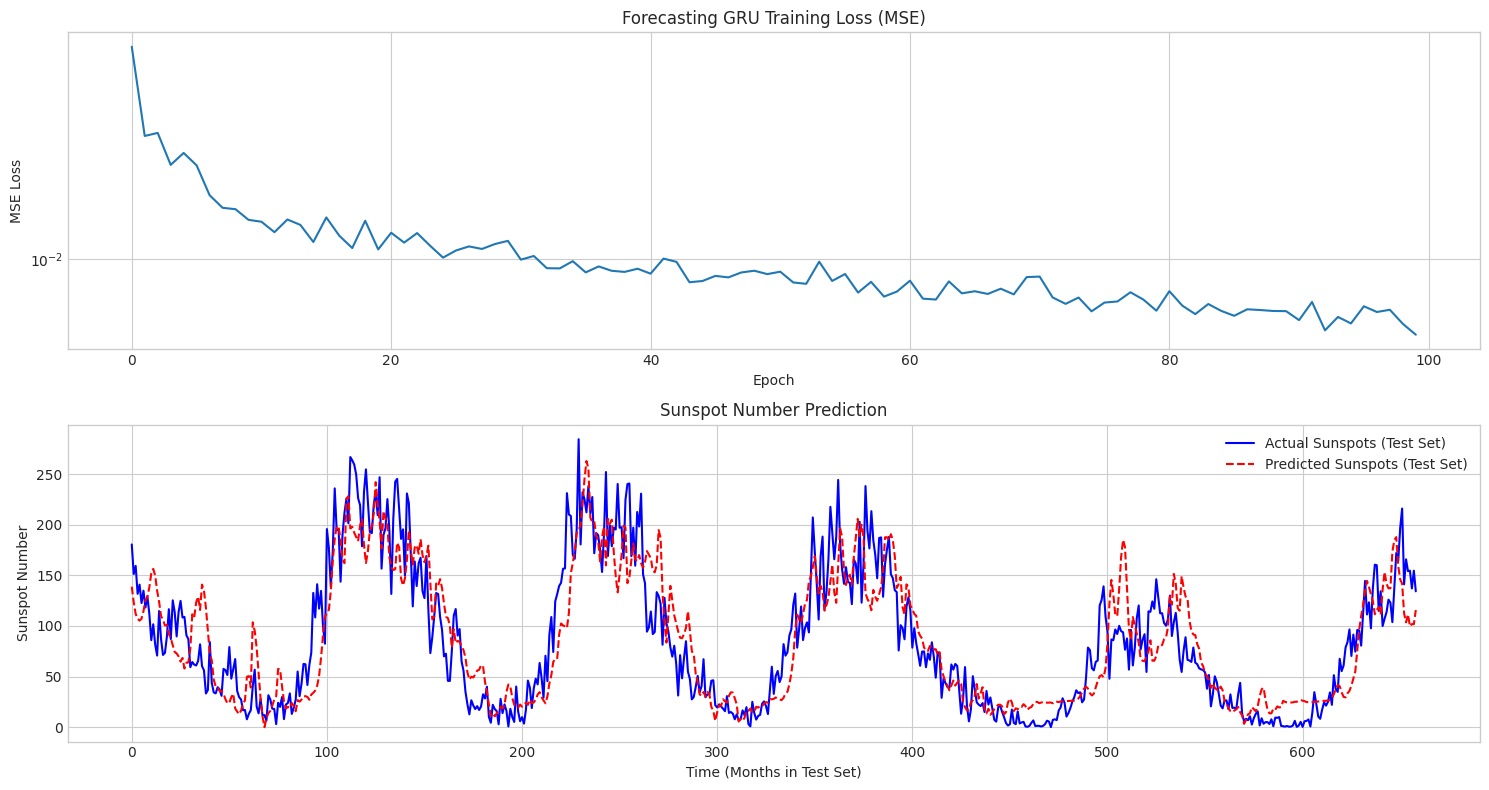


FIBONACCI FIELD TRANSFORMATION EXAMPLE (SUNSPOT WINDOW):
Sample unscaled sunspot window (12 values): [ 96.7 104.3 116.7  92.8 141.7 139.2 158.  110.5 126.5 125.8 264.3 142. ]
Initialized Fibonacci encoder with 20 Fibonacci numbers: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711]

FNNN Real-World Demonstration (Sunspot Forecasting) Setup Complete.
The FNNN successfully:
1. Encoded windows of 12 sunspot values into 20D Fibonacci fields.
2. Trained a GRU (Seq2Val) to predict the next sunspot value based on a sequence of 10 encoded windows.
3. Visualized training loss and prediction results.


In [31]:
sunspot_series = fetch_sunspot_data()

# Parameters for sunspot forecasting
ENCODER_WINDOW_SIZE = 12  # Use 12 past months to create one Fibonacci feature vector
GRU_SEQ_LEN = 10  # Use a sequence of 10 such feature vectors to predict the next month
N_FIB_NUMBERS_FORECAST = 20  # Number of Fibonacci numbers for encoding
HIDDEN_DIM_GRU_FORECAST = 50
EPOCHS_FORECAST = 100  # Increase for better results, 100 for quicker demo
LR_FORECAST = 0.002

# Create an encoder instance for forecasting
fnnn_forecaster_encoder = FibonacciTwistEncoder(
    n_fib_numbers=N_FIB_NUMBERS_FORECAST, min_fib_val=2
)

if len(sunspot_series) > ENCODER_WINDOW_SIZE + GRU_SEQ_LEN:
    train_fnnn_forecaster(
        sunspot_data=sunspot_series,
        fnnn_encoder=fnnn_forecaster_encoder,
        encoder_window_size=ENCODER_WINDOW_SIZE,
        gru_input_seq_len=GRU_SEQ_LEN,
        n_fib_numbers=N_FIB_NUMBERS_FORECAST,
        hidden_dim_gru=HIDDEN_DIM_GRU_FORECAST,
        epochs=EPOCHS_FORECAST,
        lr=LR_FORECAST,
    )
else:
    print(
        f"Sunspot series too short ({len(sunspot_series)}) for the chosen window/sequence lengths. Min required: {ENCODER_WINDOW_SIZE + GRU_SEQ_LEN + 1}"
    )

print("\nFNNN Real-World Demonstration (Sunspot Forecasting) Setup Complete.")
print("The FNNN successfully:")
print(
    f"1. Encoded windows of {ENCODER_WINDOW_SIZE} sunspot values into {N_FIB_NUMBERS_FORECAST}D Fibonacci fields."
)
print(
    f"2. Trained a GRU (Seq2Val) to predict the next sunspot value based on a sequence of {GRU_SEQ_LEN} encoded windows."
)
print("3. Visualized training loss and prediction results.")

FIBONACCI NUMBER NEURAL NETWORK - SYNTHETIC DEMONSTRATION
Initialized Fibonacci encoder with 20 Fibonacci numbers: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584, 4181, 6765, 10946, 17711]
Generating 800 synthetic sequences of length 12 for FNNN demo...
Predictor training data shape: X=torch.Size([800, 11, 20]), y=torch.Size([800, 11, 20])
Training Fibonacci Field Evolution Predictor (Synthetic Data)...
Epoch   0 - Predictor Loss: 0.66862571 - LR: 0.001000
Epoch  50 - Predictor Loss: 0.07083002 - LR: 0.001000
Epoch 100 - Predictor Loss: 0.05868964 - LR: 0.001000
Epoch 150 - Predictor Loss: 0.05627352 - LR: 0.001000
Synthetic Predictor training completed. Final loss: 0.05450391
Epoch   0 - Decoder BCE Loss: 0.691247
Epoch  50 - Decoder BCE Loss: 0.195106
Epoch 100 - Decoder BCE Loss: 0.161852
Epoch 150 - Decoder BCE Loss: 0.159279

Fibonacci Presence Decoder Classification Report (Synthetic):
              precision    recall  f1-score   support

       fib=2      

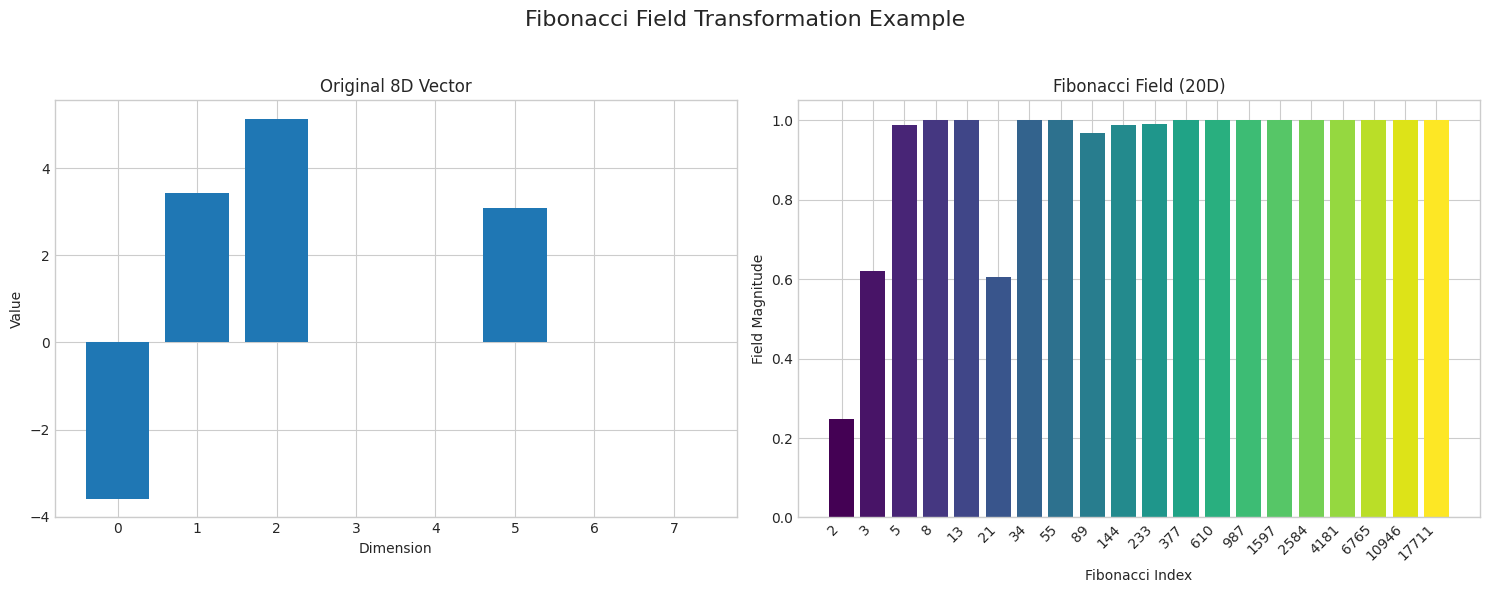

Resulting Fibonacci field (first 5 components): [0.24745503 0.62002183 0.98907411 1.         1.        ]...


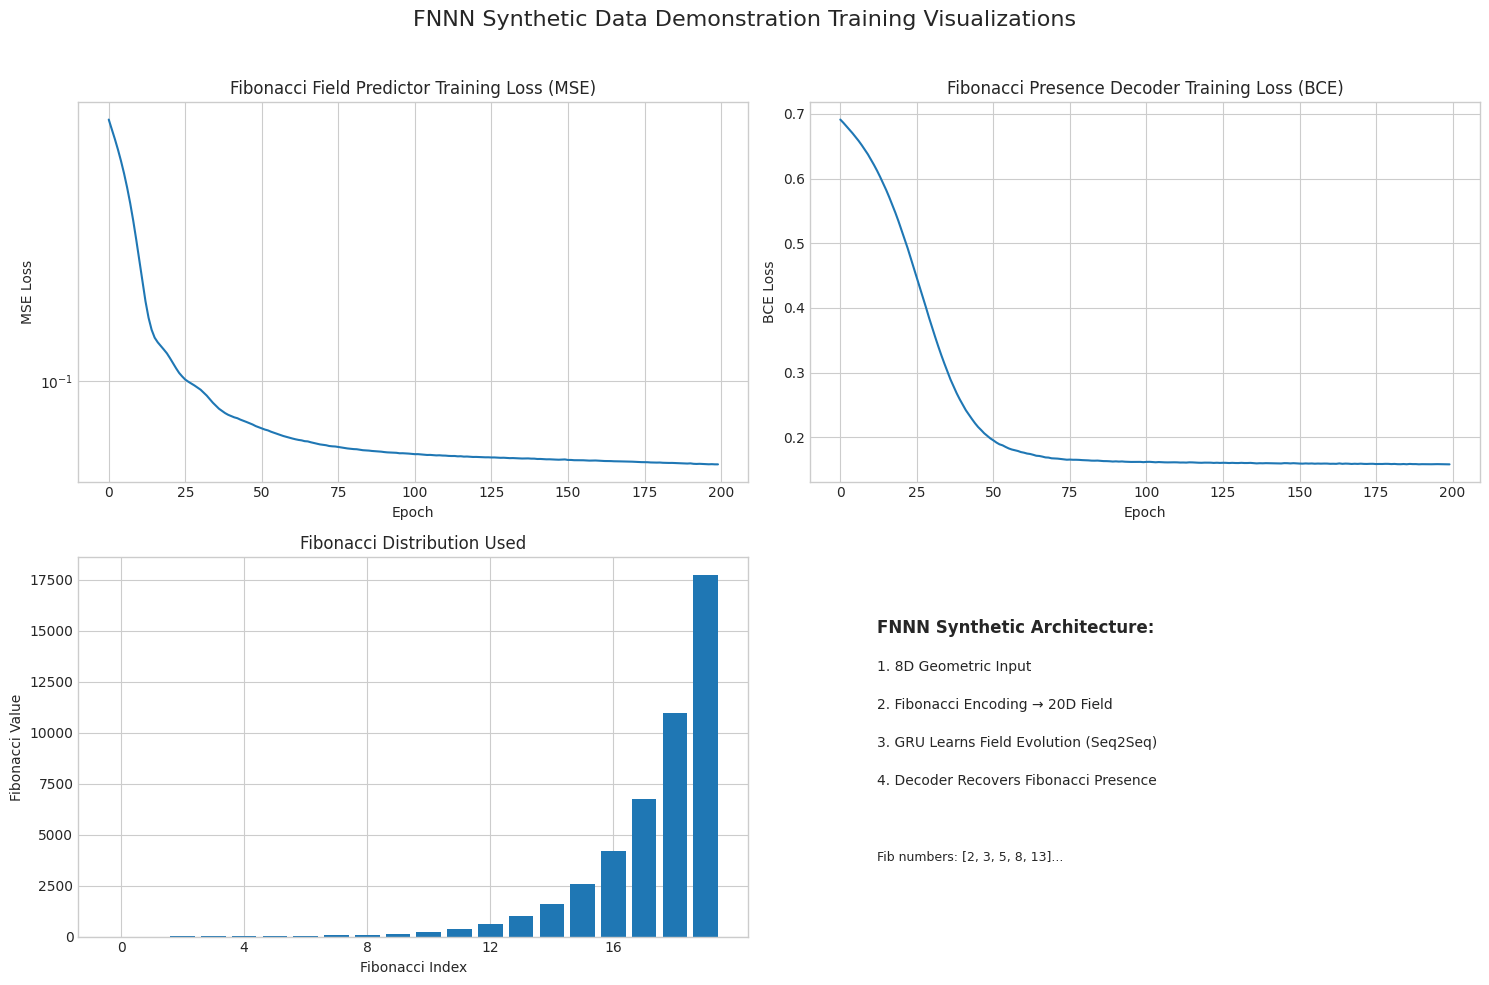


SYNTHETIC DEMONSTRATION COMPLETE!
The Fibonacci Neural Network (Synthetic Demo) successfully:
1. Encoded 8D geometry into 20D Fibonacci fields.
2. Trained a GRU to learn Fibonacci field evolution.
3. Trained a decoder to identify Fibonacci presence from field signatures.


In [32]:
def run_synthetic_fnnn_demonstration():
    print("=" * 60)
    print("FIBONACCI NUMBER NEURAL NETWORK - SYNTHETIC DEMONSTRATION")
    print("=" * 60)
    fnnn_synthetic = FibonacciNeuralNetwork(
        input_dim_encoder=8, n_fib_numbers=20, hidden_dim_gru=64, min_fib_val=2
    )
    # Generate synthetic data
    raw_sequences, fib_sequences = fnnn_synthetic.generate_synthetic_data(
        n_samples=800, seq_length=12
    )  # (batch, seq, vec_dim_encoder), (batch, seq, n_fib)
    # Prepare training data for the Fibonacci field predictor (Seq2Seq)
    # X_pred_tensor is (batch, seq-1, n_fib), y_pred_tensor is (batch, seq-1, n_fib)
    X_pred_tensor, y_pred_tensor = fnnn_synthetic.prepare_predictor_training_data(
        fib_sequences
    )
    print(
        f"Predictor training data shape: X={X_pred_tensor.shape}, y={y_pred_tensor.shape}"
    )
    # Train Fibonacci field predictor
    fnnn_synthetic.train_fib_predictor_synthetic(
        X_pred_tensor, y_pred_tensor, epochs=200, verbose=True
    )  # Reduced epochs for speed
    fnnn_synthetic.train_fib_decoder_synthetic(
        fib_sequences[:, :-1], raw_sequences, epochs=200, verbose=True
    )
    # Demonstrate Fibonacci field transformation
    print("\n" + "=" * 50)
    print("FIBONACCI FIELD TRANSFORMATION EXAMPLE (SYNTHETIC):")
    print("=" * 50)
    sample_vector_synthetic = raw_sequences[0, 0, :]  # First vector of first sequence
    print(
        f"Sample {fnnn_synthetic.input_dim_encoder}D vector: {sample_vector_synthetic}"
    )
    fib_field_example = fnnn_synthetic.demonstrate_fibonacci_field(
        sample_vector_synthetic
    )
    print(f"Resulting Fibonacci field (first 5 components): {fib_field_example[:5]}...")

    # Visualize training
    fnnn_synthetic.visualize_training_synthetic()

    print("\n" + "=" * 60)
    print("SYNTHETIC DEMONSTRATION COMPLETE!")
    print("The Fibonacci Neural Network (Synthetic Demo) successfully:")
    print(
        f"1. Encoded {fnnn_synthetic.input_dim_encoder}D geometry into {fnnn_synthetic.n_fib_numbers}D Fibonacci fields."
    )
    print("2. Trained a GRU to learn Fibonacci field evolution.")
    print("3. Trained a decoder to identify Fibonacci presence from field signatures.")
    print("=" * 60)

    return fnnn_synthetic


# Run the synthetic demonstration
fnnn_synthetic_model = run_synthetic_fnnn_demonstration()